### Team 24 - Question 2

### Import statements 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.svm import SVC
import seaborn as sns

### Function definitions

In [2]:
def accuracy(Y_true, Y_pred):
    
# Returns the accuracy of predicted classes
# Inputs:
#     Y_true -----> True class labels
#     Y_pred -----> Predicted class labels
# Returns:
#     tp/N -------> Accuracy of predicted class labels 

    tp = len(np.argwhere(Y_true==Y_pred))
    N  = Y_true.shape[0]
    return tp/N

In [3]:
def confusion_matrix_plot(Y_true, Y_pred, return_mat = False, title_suffix=None):
    
# Plots and returns the confusion matrix (if asked) given the predictions and the the true labels
# Inputs:
#     Y_true ------> True class labels
#     Y_pred ------> Predicted class labels
#     return_mat --> Flag to specify if confusion matrix should be returned 
# Returns:
#     conf_mat ------> Confusion Matrix (if return_mat=True)

    n_classes = len(np.unique(Y_true))
    conf_mat = np.zeros((n_classes,n_classes))
    for i in range(n_classes):
        for j in range(n_classes):
            true_i = np.argwhere(Y_true==i).ravel()
            pred_j = np.argwhere(Y_pred==j).ravel()
            conf_mat[i][j] = int(len(np.intersect1d(true_i, pred_j)))
    
    conf_percentage = np.around((conf_mat*100/np.sum(conf_mat)), decimals=2)
    conf_percentage = np.array(list(map(lambda x: str(x) +'%', conf_percentage.ravel()))).reshape(n_classes,n_classes)
    
    h = np.around(list(np.diag(conf_mat)*100/np.sum(conf_mat, axis = 0)) + [100*np.sum(np.diag(conf_mat))/np.sum(conf_mat)], decimals=1)
    h_neg = np.around(list(100 - h), decimals=1)
    v = np.around(np.diag(conf_mat)*100/np.sum(conf_mat, axis = 1), decimals=1)
    v_neg = np.around(100 - v, decimals=1)

    v_new = np.array(list(map(lambda x: str(x) +'%', v)))
    h_new = np.array(list(map(lambda x: str(x) +'%', h)))
    
    v_neg_new = np.array(list(map(lambda x: str(x) +'%', v_neg)))
    h_neg_new = np.array(list(map(lambda x: str(x) +'%', h_neg)))
    
    
    label_up = np.vstack((np.vstack((conf_mat.astype(str).T,v_new)).T, h_new))
    label_down = np.vstack((np.vstack((conf_percentage.astype(str).T,v_neg_new)).T, h_neg_new))
    label_all = np.array(list(map(lambda x, y: str(x) + '\n' + str(y), list(label_up.ravel()), list(label_down.ravel())))).reshape(n_classes+1, n_classes+1)
    
    dummy = (np.min(conf_mat)+np.max(conf_mat))/2
    labels = ['Class {}'.format(c) for c in list(np.unique(Y).astype(str))] + ['Sum']
    conf_df = pd.DataFrame(np.vstack((np.vstack((conf_mat,np.array([dummy]*n_classes))).T,[dummy]*(n_classes+1))), index = labels, columns = labels)
    
    sns.set(rc={'figure.figsize':(6,6)})
    ax = sns.heatmap(conf_df, annot=label_all, fmt = '', annot_kws={"size": 15}, cbar=False, cmap='summer', linecolor='k', linewidths=.1, square= True) 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_facecolor("grey")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if title_suffix == None:
        plt.title('Confusion Matrix')
    else:
        plt.title('Confusion Matrix - ' + title_suffix)
    plt.show()
            
    if return_mat == True:
        return conf_mat              

In [4]:
def decision_region(x_train, y_train, svc_clf):
    
# Plots the decision region
# Inputs:
#     x_train ---------> Training Datapoints
#     y_train ---------> Class labels for x_train
#     svc_clf --------->

# Returns:
#     None  

    x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
    y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    h = .2  
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    x = np.c_[xx.ravel(), yy.ravel()]
    y_pred = svc_clf.predict(x)
    support_vectors = svc_clf.support_vectors_
    y_pred = np.array(y_pred).reshape(xx.shape)
    classes = np.unique(y_train).astype(str)
    
    plt.style.use('classic')
    plt.pcolormesh(xx, yy, y_pred, cmap=plt.cm.Paired)
    scatter = plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
    scatter_sv = plt.scatter(support_vectors[:,0], support_vectors[:,1], c='g', edgecolors='k')
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary: ")
    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.legend(handles=scatter.legend_elements()[0] + [scatter_sv], labels=list(map(lambda x: 'Class {}'.format(x), classes))+['Support vectors'])
    plt.show()

### Loading the Dataset

In [5]:
import os
os.getcwd()
os.chdir('/home/achusanjeev/PRML_Data_Contest/PA2_Datasets/Dataset_2')

In [6]:
data = pd.read_csv('Dataset_2_Team_24.csv')
data.head()

,# x_1,x_2,Class_label
0,1.126566,0.426970,0
1,-0.384719,0.896004,0
2,-0.099962,0.881292,0
3,0.123893,-0.094826,1
4,1.458488,-0.250462,1


In [7]:
np.random.seed(3)

In [8]:
X = np.vstack((data[data.columns[0]].values, data[data.columns[1]].values)).T
Y = data[data.columns[-1]].values

N = X.shape[0]
train_N = int(0.8*N)
order = list(range(N))
np.random.shuffle(order)

X_train = X[order[:train_N],:]
Y_train = Y[order[:train_N]]
X_test = X[order[train_N:],:]
Y_test = Y[order[train_N:]] 

### Visualising the data

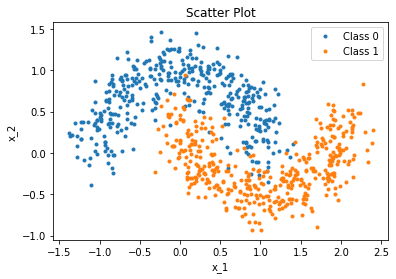

In [9]:
classes = np.unique(Y_train)
for c in classes:
    x_c = X_train[np.argwhere(Y_train==c).ravel(),:]
    plt.plot(x_c[:,0], x_c[:,1],'.')
    
plt.title('Scatter Plot')
plt.legend(['Class 0','Class 1','Class 2'])
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show() 

In [10]:
Y_pred_train = []
Y_pred_test = []
SVC_model_trained = []

C_list = [0.01, 0.1, 1, 10, 100]

for C in C_list:
    svc_clf = SVC(C, gamma = 'scale') 
    svc_clf.fit(X_train, Y_train)
    SVC_model_trained.append(svc_clf)
    Y_pred_train.append(svc_clf.predict(X_train))
    Y_pred_test.append(svc_clf.predict(X_test))     

In [11]:
table = []
headers = ["C value", "Train Accuracy", "Test Accuracy"]
 
    
for i in range(len(C_list)):
    table.append([C_list[i], accuracy(Y_train, Y_pred_train[i]), accuracy(Y_test, Y_pred_test[i])])

print(tabulate(table, headers, tablefmt = 'fancy_grid'))


╒═══════════╤══════════════════╤═════════════════╕
│   C value │   Train Accuracy │   Test Accuracy │
╞═══════════╪══════════════════╪═════════════════╡
│      0.01 │          0.87625 │           0.875 │
├───────────┼──────────────────┼─────────────────┤
│      0.1  │          0.9425  │           0.965 │
├───────────┼──────────────────┼─────────────────┤
│      1    │          0.95625 │           0.97  │
├───────────┼──────────────────┼─────────────────┤
│     10    │          0.96    │           0.965 │
├───────────┼──────────────────┼─────────────────┤
│    100    │          0.96    │           0.955 │
╘═══════════╧══════════════════╧═════════════════╛


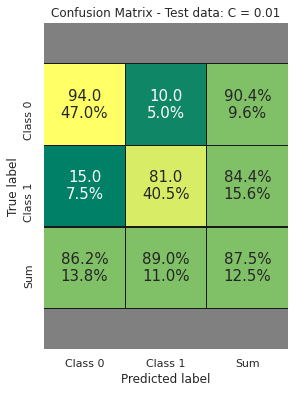

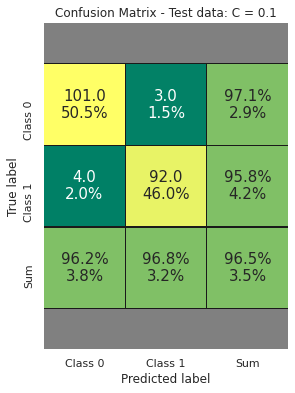

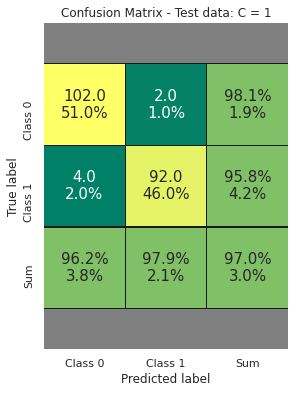

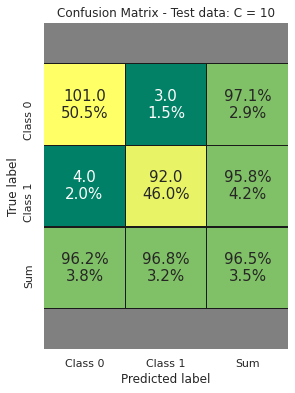

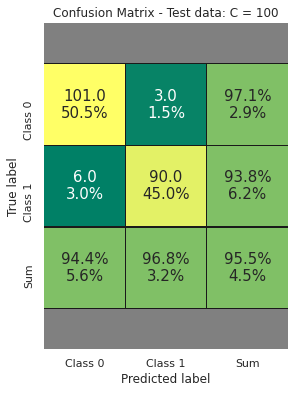

In [12]:
for i in range(len(C_list)):
    confusion_matrix_plot(Y_test, Y_pred_test[i], title_suffix='Test data: C = {}'.format(C_list[i]))

In [13]:
X_train

array([[ 0.35787854,  1.01557308],
       [-0.25074463,  0.8936365 ],
       [ 1.1730322 ,  0.58071667],
       ...,
       [ 0.81895091,  0.87740064],
       [ 1.55048454, -0.39794348],
       [ 1.16396203, -0.5982493 ]])

/home/achusanjeev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


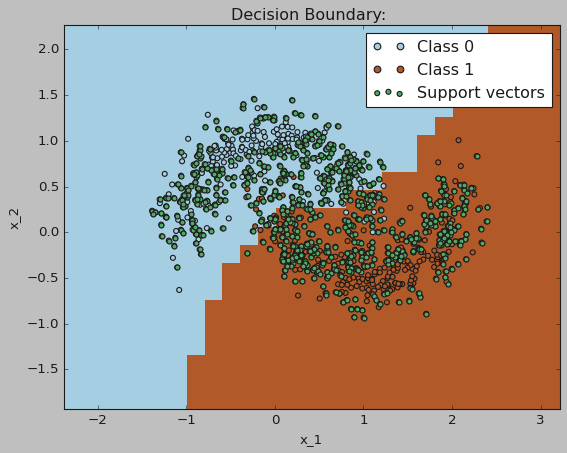

/home/achusanjeev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


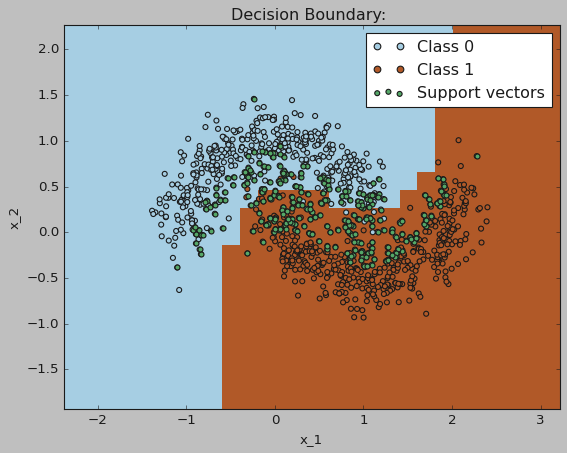

/home/achusanjeev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


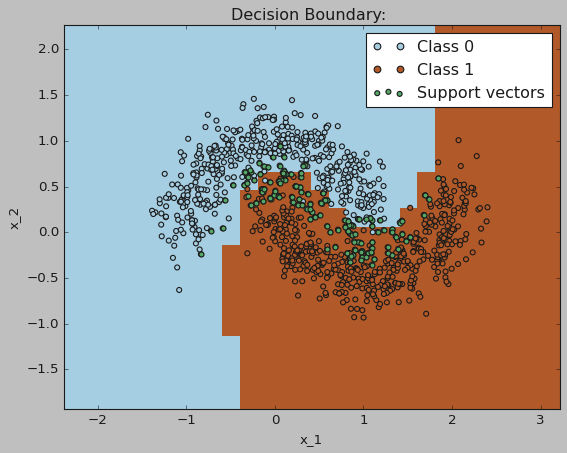

/home/achusanjeev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


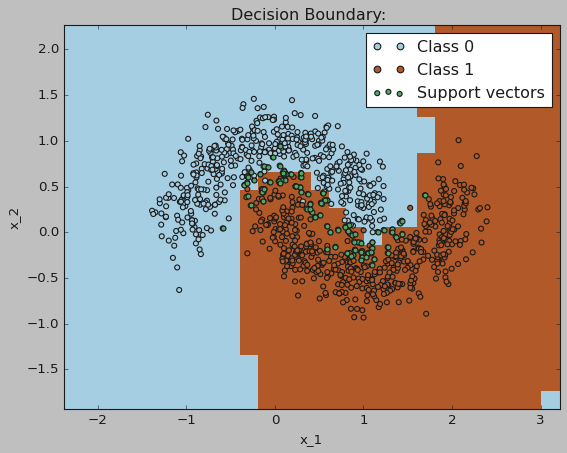

/home/achusanjeev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


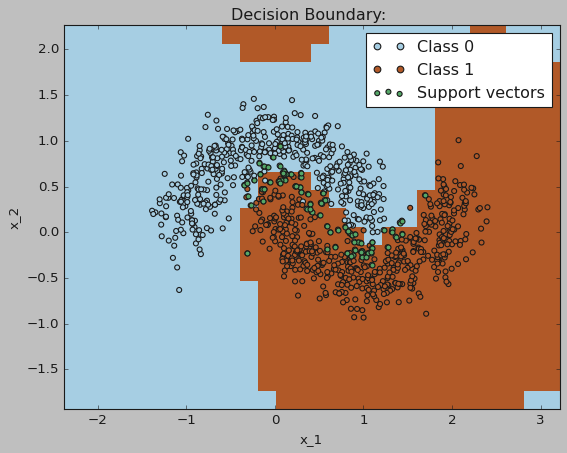

In [14]:
for svc_clf in SVC_model_trained:
    decision_region(X, Y, svc_clf)

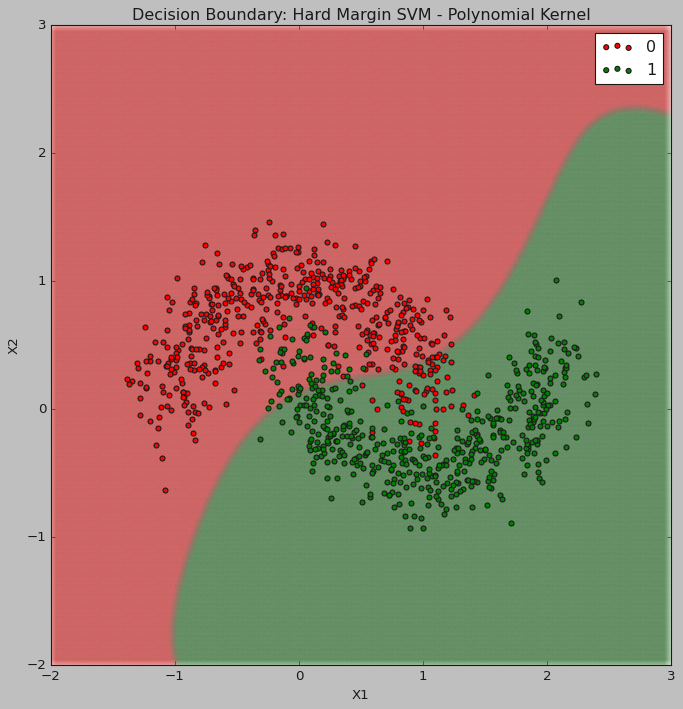

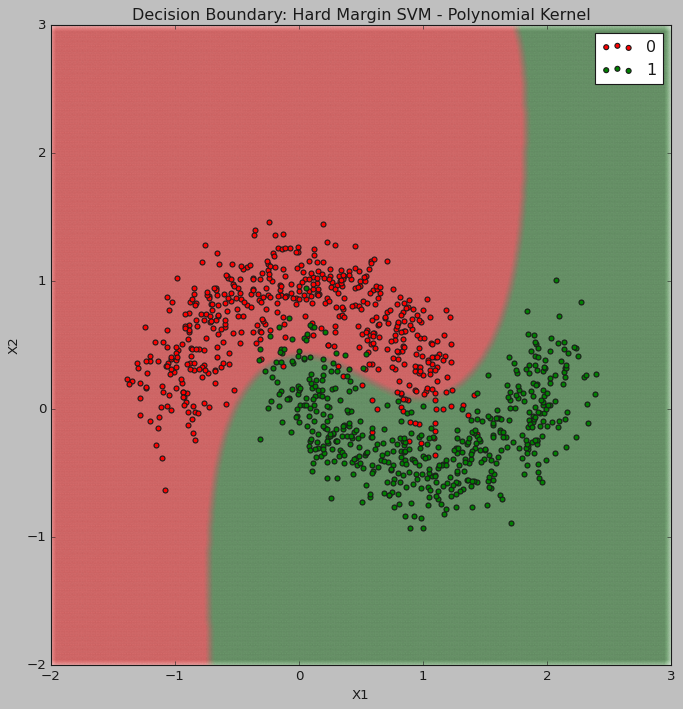

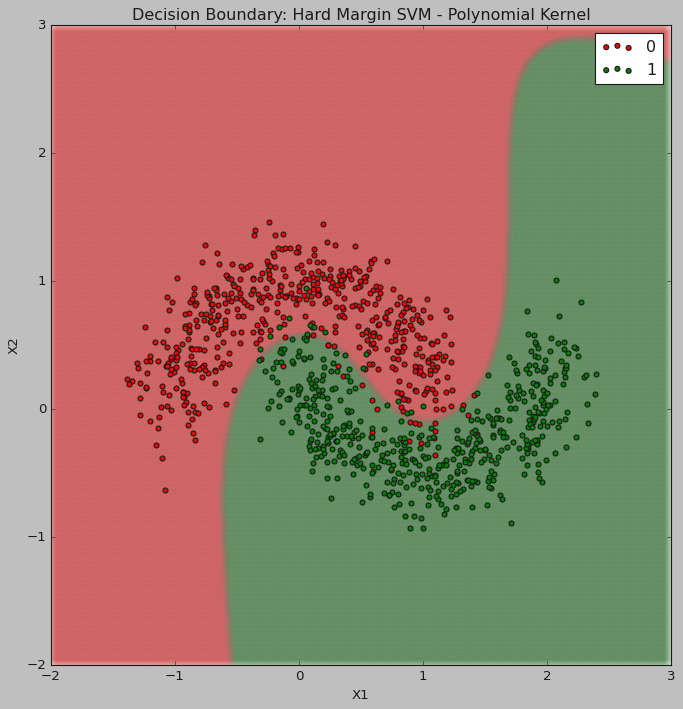

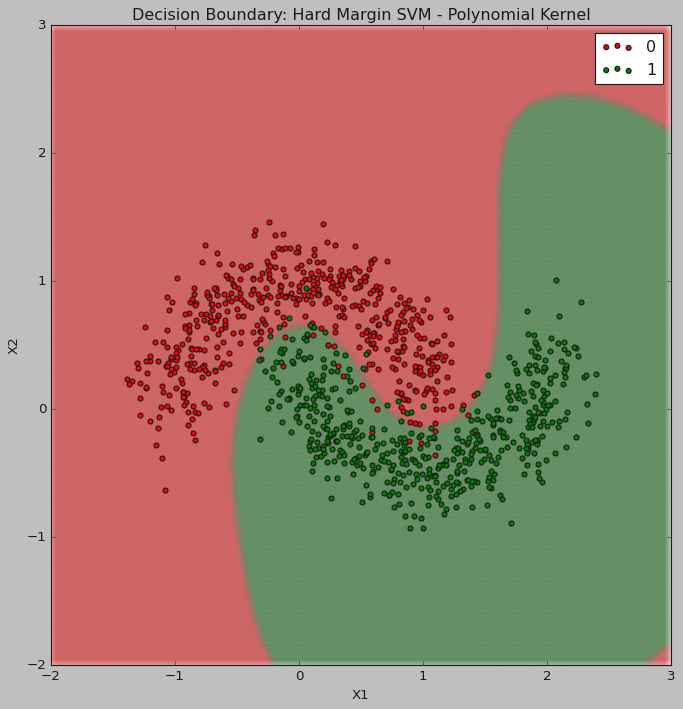

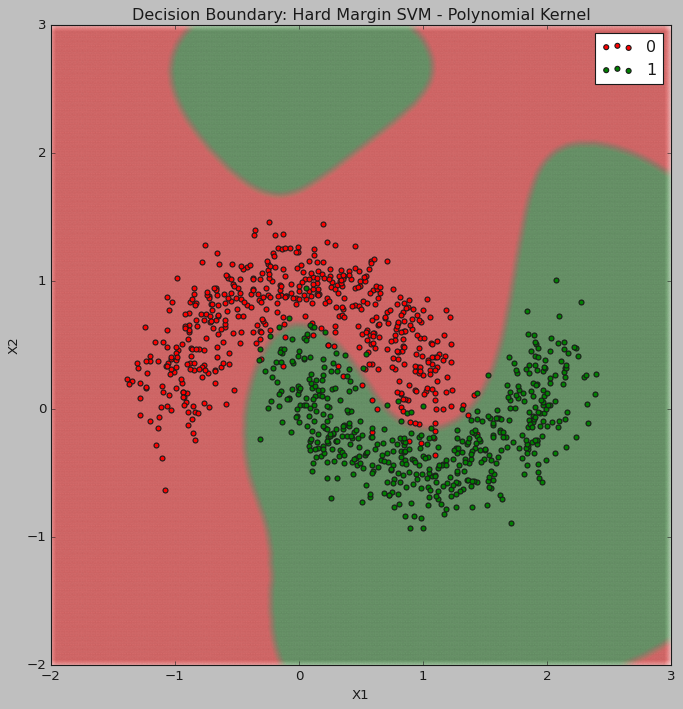

In [15]:
# Plotting decision boundary

for svc_clf in SVC_model_trained:

    xx, yy = np.meshgrid(np.arange(-2, 3, 0.01), np.arange(-2, 3, 0.01))
    x_plot = np.c_[xx.ravel(), yy.ravel()]

    plt.figure(figsize=[10,10])

    cdict = {0: 'red', 1: 'green'}

    y_plot = svc_clf.predict(x_plot).astype(int)

    plt.scatter(x_plot[:,0], x_plot[:,1], c = pd.Series(y_plot).apply(lambda x: cdict[x]), s =100, alpha=0.008)

    plt.title("Decision Boundary: Hard Margin SVM - Polynomial Kernel")
    plt.xlim(left=-2, right =3)
    plt.ylim(bottom=-2, top =3)
    plt.xlabel('X1')
    plt.ylabel('X2')


    for g in np.unique(Y):
        ix = np.where(Y == g)
        plt.scatter(X[:,0][ix], X[:,1][ix], c = cdict[g], label = g)
    plt.legend()  

    plt.xlabel('X1')
    plt.ylabel('X2')

    plt.show() 

In [16]:
table = []
headers = ["C value", "Number of Support\n Vectors for Class 0", "Number of Support\n Vectors for Class 1"]
 
    
for i in range(len(C_list)):
    
    table.append([C_list[i], SVC_model_trained[i].n_support_[np.argwhere(SVC_model_trained[i].classes_==0)], SVC_model_trained[i].n_support_[np.argwhere(SVC_model_trained[i].classes_==1)]])

print(tabulate(table, headers, tablefmt = 'fancy_grid'))    

╒═══════════╤════════════════════════╤════════════════════════╕
│   C value │      Number of Support │      Number of Support │
│           │    Vectors for Class 0 │    Vectors for Class 1 │
╞═══════════╪════════════════════════╪════════════════════════╡
│      0.01 │                    332 │                    330 │
├───────────┼────────────────────────┼────────────────────────┤
│      0.1  │                    134 │                    132 │
├───────────┼────────────────────────┼────────────────────────┤
│      1    │                     66 │                     66 │
├───────────┼────────────────────────┼────────────────────────┤
│     10    │                     44 │                     44 │
├───────────┼────────────────────────┼────────────────────────┤
│    100    │                     38 │                     39 │
╘═══════════╧════════════════════════╧════════════════════════╛


In [17]:
k_list = [2, 4, 8, 16]
Y_pred_train_k = []
Y_pred_test_k = []
SVC_model_trained_k = []

for i in range(len(k_list)):
    Y_pred_train = []
    Y_pred_test = []
    SVC_model_trained = []
    for C in C_list:
        class_weights = {0:k_list[i], 1:1}
        svc_clf = SVC(C, gamma = 'scale', class_weight=class_weights) 
        svc_clf.fit(X_train, Y_train)
        SVC_model_trained.append(svc_clf)
        Y_pred_train.append(svc_clf.predict(X_train))
        Y_pred_test.append(svc_clf.predict(X_test))
                                           
    Y_pred_train_k.append(Y_pred_train)
    Y_pred_test_k.append(Y_pred_test)
    SVC_model_trained_k.append(SVC_model_trained)

In [18]:
table = [[], [], [], [], []]
headers = ["k value", "Train Accuracy", "Test Accuracy", "Number of Support\n Vectors for Class 0", "Number of Support\n Vectors for Class 1"]

for i in range(len(k_list)):
    for j in range(len(C_list)):
        table[j].append([k_list[i], accuracy(Y_train, Y_pred_train_k[i][j]), accuracy(Y_test, Y_pred_test_k[i][j]), SVC_model_trained_k[i][j].n_support_[np.argwhere(SVC_model_trained_k[i][j].classes_==0)], SVC_model_trained_k[i][j].n_support_[np.argwhere(SVC_model_trained_k[i][j].classes_==1)]])        

for j in range(len(C_list)):
    print('C = {0}'.format(C_list[j]))
    print(tabulate(table[j], headers, tablefmt = 'fancy_grid'))    

C = 0.01
╒═══════════╤══════════════════╤═════════════════╤════════════════════════╤════════════════════════╕
│   k value │   Train Accuracy │   Test Accuracy │      Number of Support │      Number of Support │
│           │                  │                 │    Vectors for Class 0 │    Vectors for Class 1 │
╞═══════════╪══════════════════╪═════════════════╪════════════════════════╪════════════════════════╡
│         2 │          0.88125 │           0.885 │                    197 │                    389 │
├───────────┼──────────────────┼─────────────────┼────────────────────────┼────────────────────────┤
│         4 │          0.80625 │           0.77  │                    104 │                    404 │
├───────────┼──────────────────┼─────────────────┼────────────────────────┼────────────────────────┤
│         8 │          0.59125 │           0.565 │                     54 │                    404 │
├───────────┼──────────────────┼─────────────────┼────────────────────────┼───────

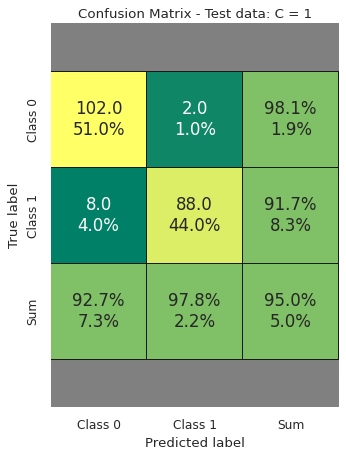

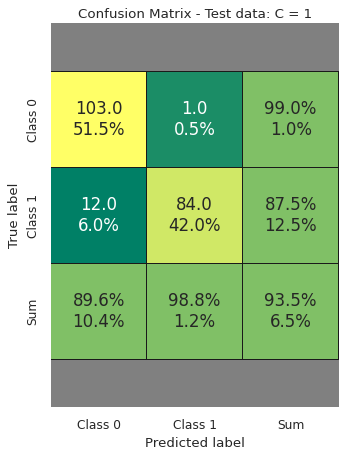

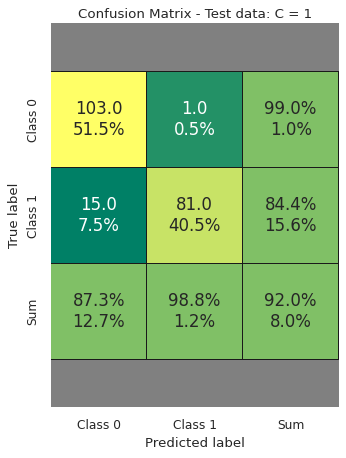

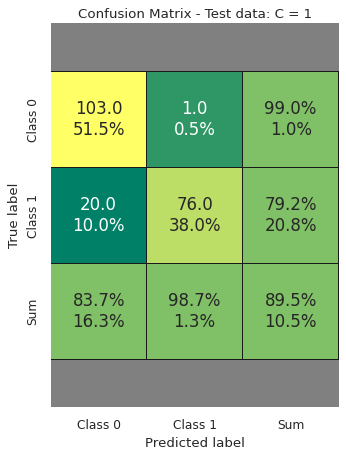

In [19]:
for i in range(len(k_list)):
    for j in range(len(C_list)):
        if C_list[j]==1:
            confusion_matrix_plot(Y_test, Y_pred_test_k[i][j], title_suffix='Test data: C = {}'.format(C_list[j]))

/home/achusanjeev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


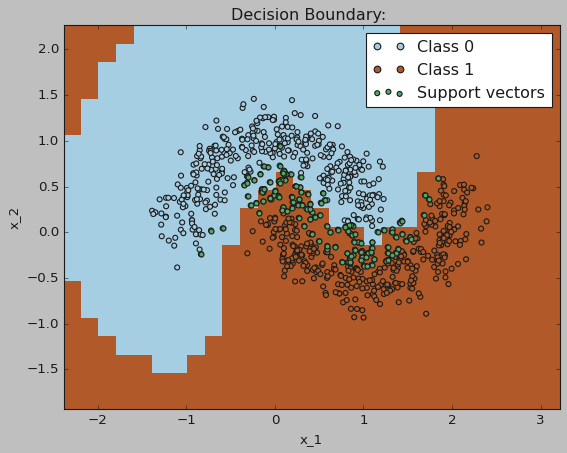

/home/achusanjeev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


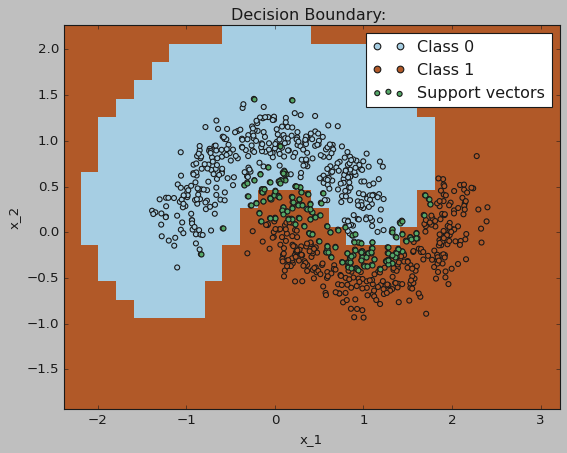

/home/achusanjeev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


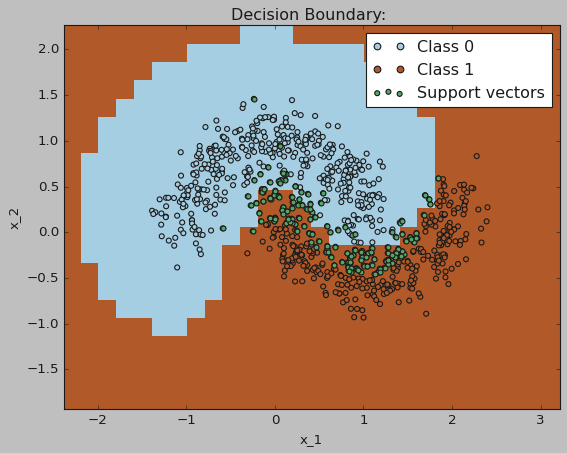

/home/achusanjeev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


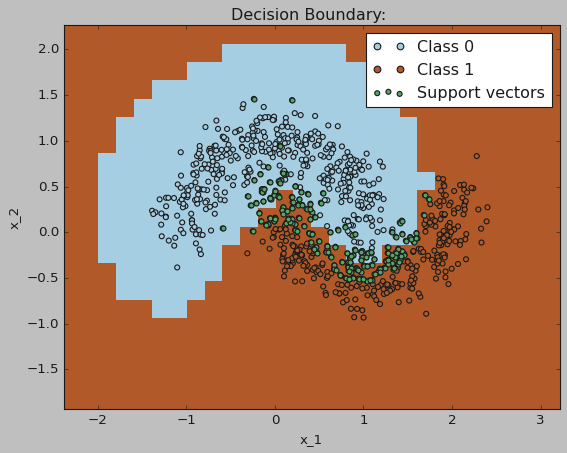

In [20]:
for i in range(len(k_list)):
    for j in range(len(C_list)):
        if C_list[j]==1:
            decision_region(X_train, Y_train, SVC_model_trained_k[i][j]) 

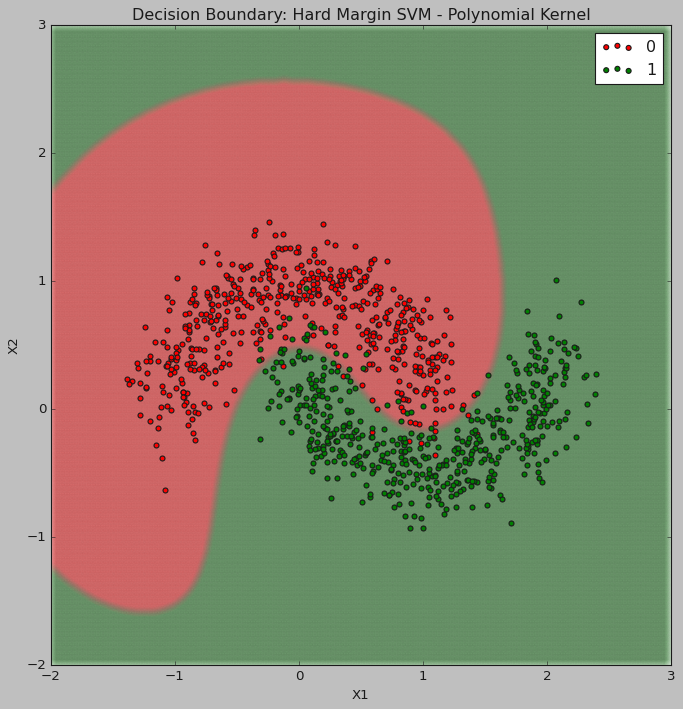

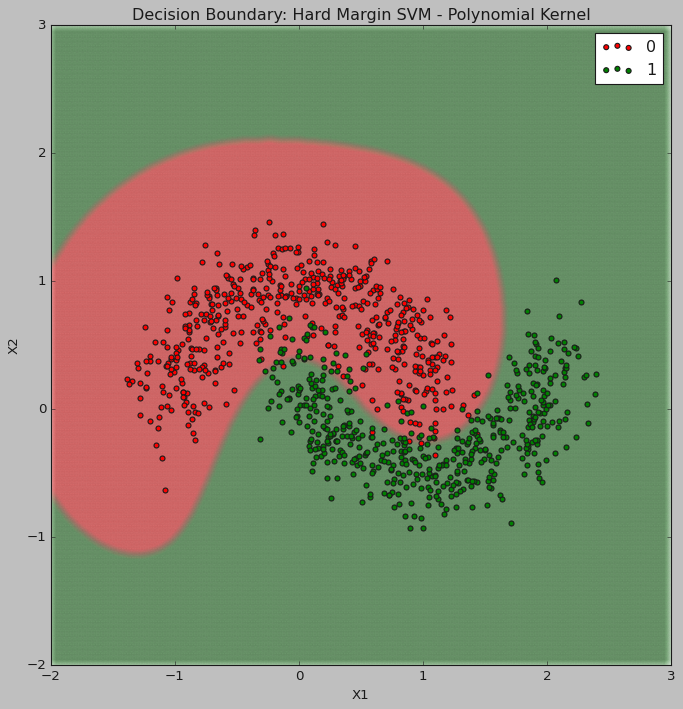

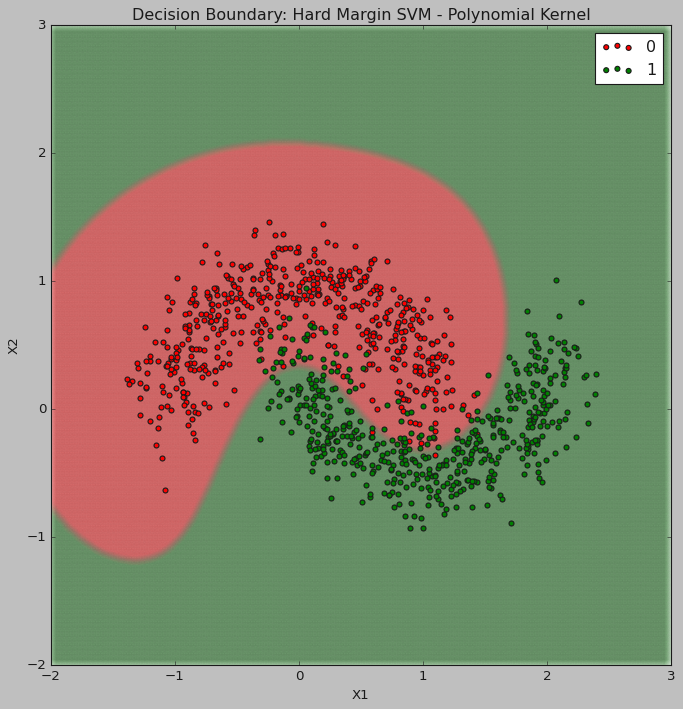

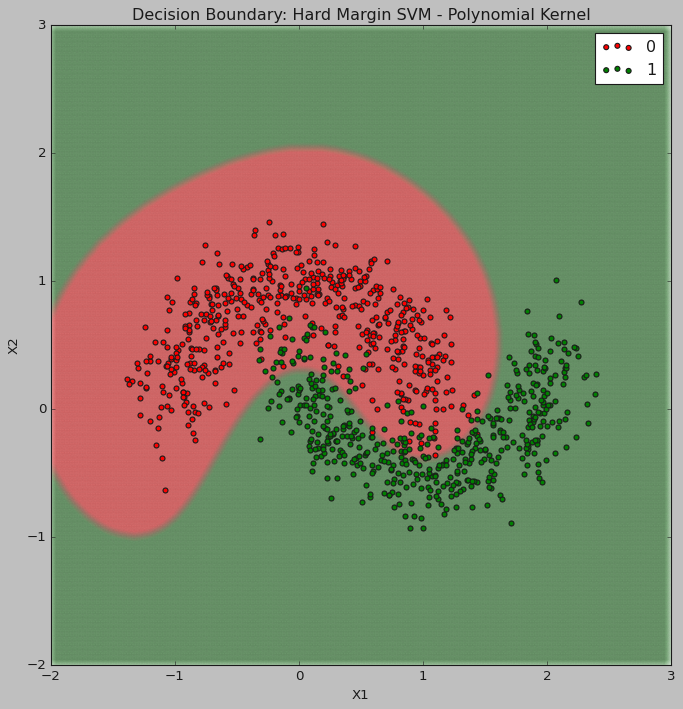

In [21]:
for i in range(len(k_list)):
    for j in range(len(C_list)):
        if C_list[j]==1:

            xx, yy = np.meshgrid(np.arange(-2, 3, 0.01), np.arange(-2, 3, 0.01))
            x_plot = np.c_[xx.ravel(), yy.ravel()]

            plt.figure(figsize=[10,10])

            cdict = {0: 'red', 1: 'green'}

            y_plot = SVC_model_trained_k[i][j].predict(x_plot).astype(int)

            plt.scatter(x_plot[:,0], x_plot[:,1], c = pd.Series(y_plot).apply(lambda x: cdict[x]), s =100, alpha=0.008)

            plt.title("Decision Boundary: Hard Margin SVM - Polynomial Kernel")
            plt.xlim(left=-2, right =3)
            plt.ylim(bottom=-2, top =3)
            plt.xlabel('X1')
            plt.ylabel('X2')


            for g in np.unique(Y):
                ix = np.where(Y == g)
                plt.scatter(X[:,0][ix], X[:,1][ix], c = cdict[g], label = g)
            plt.legend()  

            plt.xlabel('X1')
            plt.ylabel('X2')

            plt.show() 